In [47]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate
import seaborn as sns


# PARAMS

+---------------+------+-------+-------+----------+--------------+---------------+
|    dataset    | beta | gamma | delta | accuracy | fitness_norm | spearman_corr |
+---------------+------+-------+-------+----------+--------------+---------------+
| breast_cancer | 0.5  | 0.75  | 0.05  |  0.956   |    0.482     |     0.121     |
|    digits     | 0.75 | 0.25  | 0.05  |  0.941   |    0.785     |     0.273     |
|     pima      | 0.5  |  0.5  | 0.05  |  0.726   |    0.613     |     0.009     |
|     wine      | 0.75 | 0.75  | 0.05  |  0.968   |    0.706     |     0.114     |
+---------------+------+-------+-------+----------+--------------+---------------+


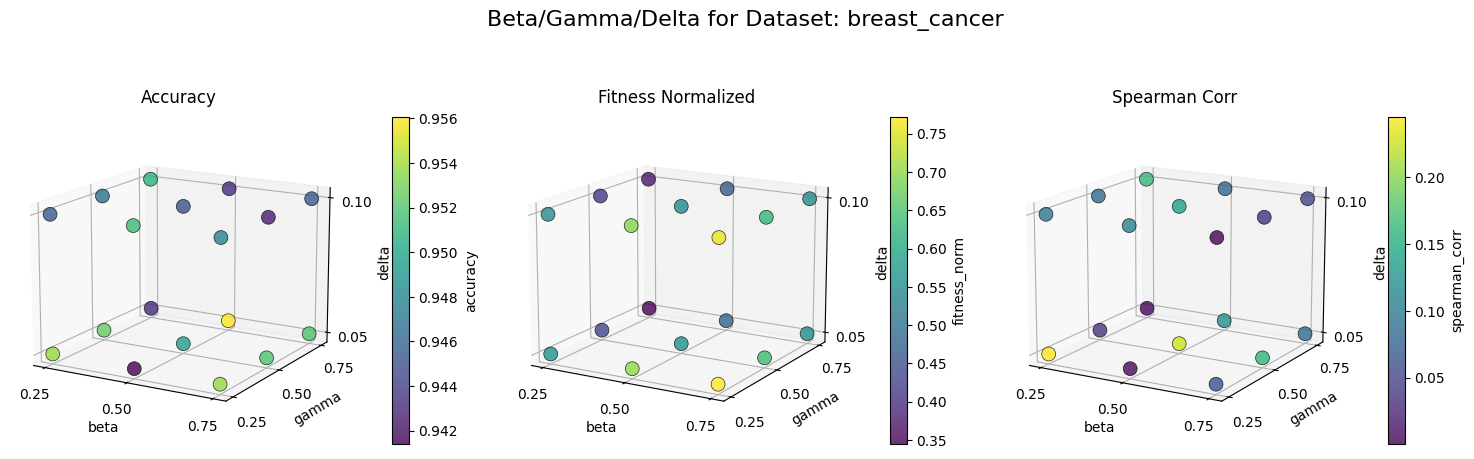

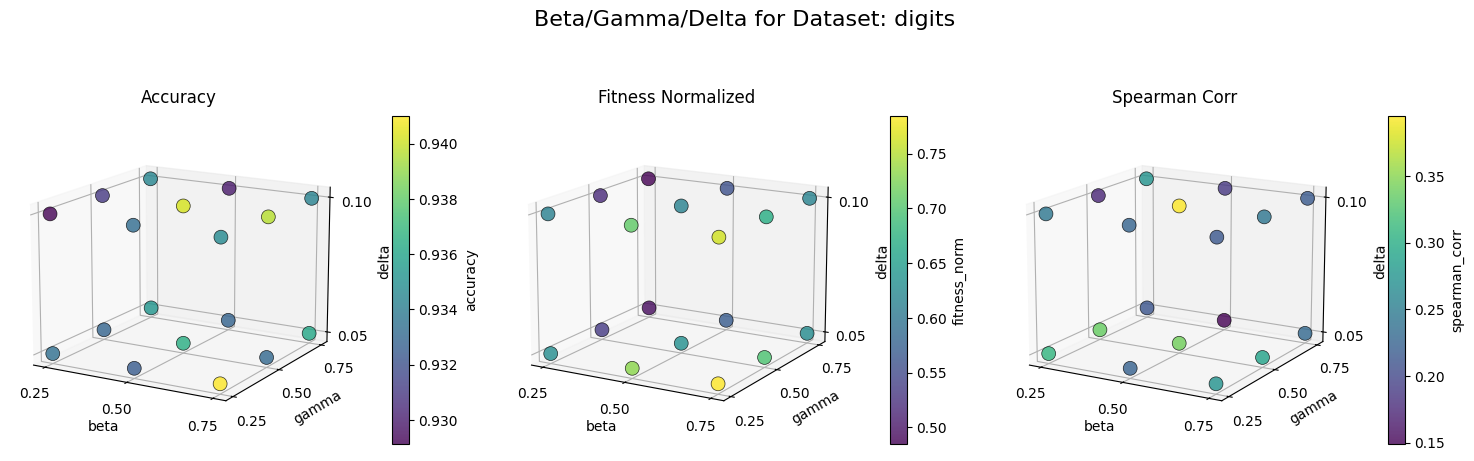

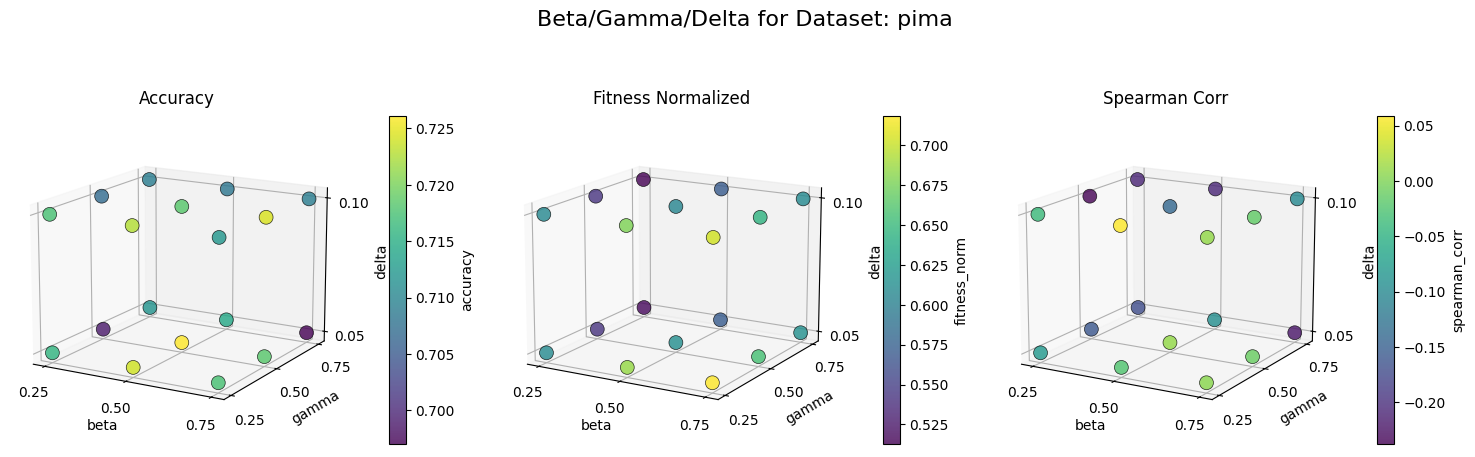

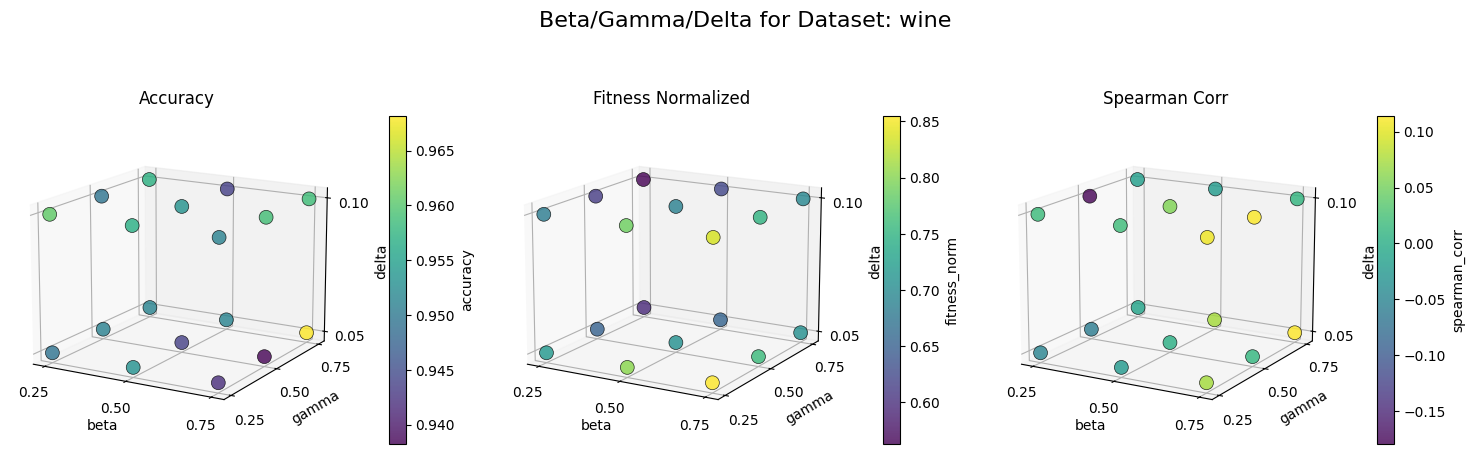

In [58]:
greeks = ['beta', 'gamma', 'delta']

files = glob.glob('./../res/params_*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df = df[df['delta'] != 0.01]

df['fitness_norm'] = (df['fitness'] + df['epsilon']) / (df['beta'] + df['gamma'] + df['epsilon'])

grouped = df.groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

grouped_corr = df[df['spearman_p'] < 0.05].groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['accuracy'].idxmax()]
tmp = best_by_dataset.copy().round(3)
print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))


# 3D Scatter Plot Function
def plot_metrics_3d_subplots(df, dataset, metrics, titles, themes):
    fig = plt.figure(figsize=(15, 5))  # Adjust figure size for subplots
    fig.suptitle(f"Beta/Gamma/Delta for Dataset: {dataset}", fontsize=16, x=0.5)
    for i, (metric, title, theme) in enumerate(zip(metrics, titles, themes), start=1):
        df_tmp = df[df['dataset'] == dataset]
        ax = fig.add_subplot(1, 3, i, projection='3d')  # Create a subplot for each metric
        sc = ax.scatter(
            df_tmp[greeks[0]], 
            df_tmp[greeks[1]], 
            df_tmp[greeks[2]], 
            c=df_tmp[metric], 
            cmap=theme, 
            s=100, 
            depthshade=True,
            edgecolor='k',  # Add black edges to improve point visibility
            linewidth=0.5,
            alpha=0.8  # Slight transparency helps with overlapping points
        )
        ax.set_xlabel(greeks[0])
        ax.set_ylabel(greeks[1])
        ax.set_zlabel(greeks[2])
        ax.set_title(title)
        
        ax.set_xticks(df_tmp[greeks[0]].unique())
        ax.set_yticks(df_tmp[greeks[1]].unique())
        ax.set_zticks(df_tmp[greeks[2]].unique())
        
        # ax.grid(True, linestyle='--', alpha=0.5)
        # ax.view_init(elev=15, azim=30)
        ax.view_init(elev=15)
        
        # Adjust colorbar position and size
        cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and add padding
        cbar.set_label(metric)
        
        # # Add numeric annotations
        # for _, row in df_tmp.iterrows():
        #     ax.text(row[greeks[0]], row[greeks[1]], row[greeks[2]], f"{row[metric]:.2f}", fontsize=8, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()

datasets = grouped['dataset'].unique()

# Define metrics, titles, and themes for the subplots
metrics = ['accuracy', 'fitness_norm', 'spearman_corr']
titles = [
    'Accuracy',
    'Fitness Normalized',
    'Spearman Corr'
]
themes = ['viridis', 'viridis', 'viridis']

# Generate subplots for each dataset
for dataset in datasets:
    plot_metrics_3d_subplots(grouped, dataset, metrics, titles, themes)

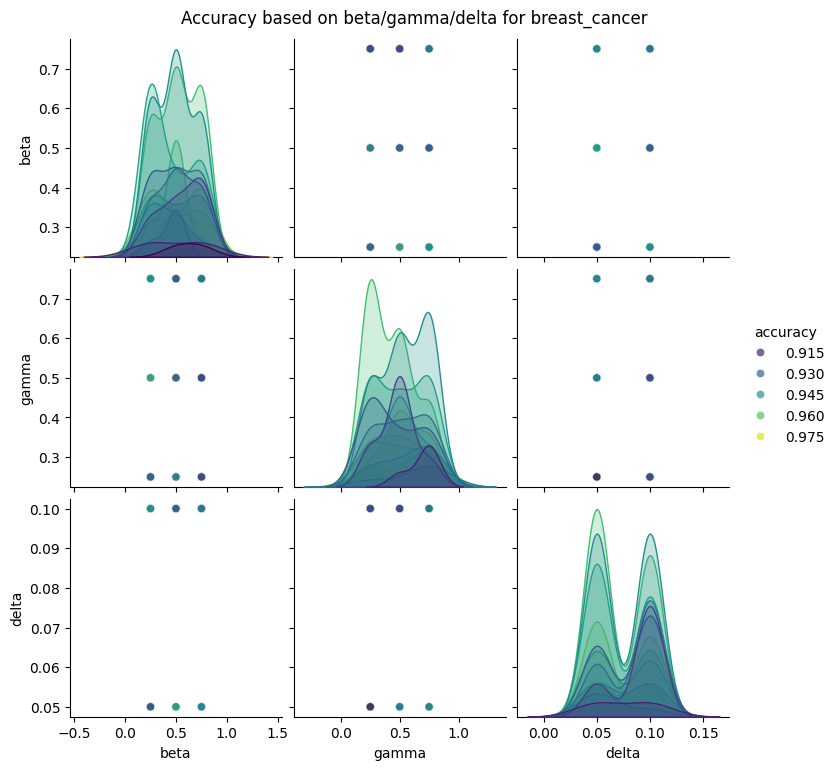

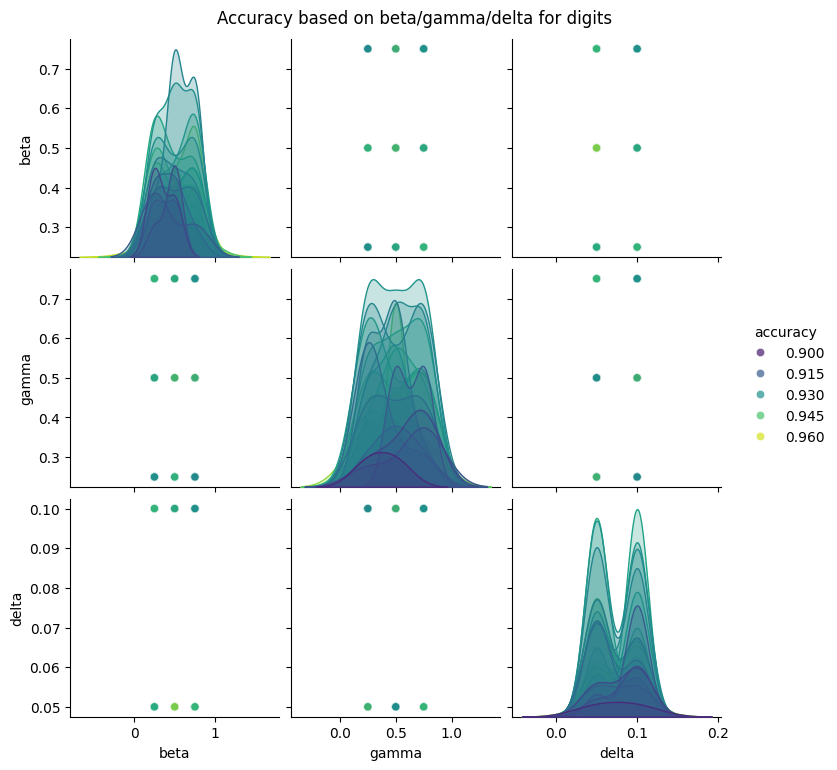

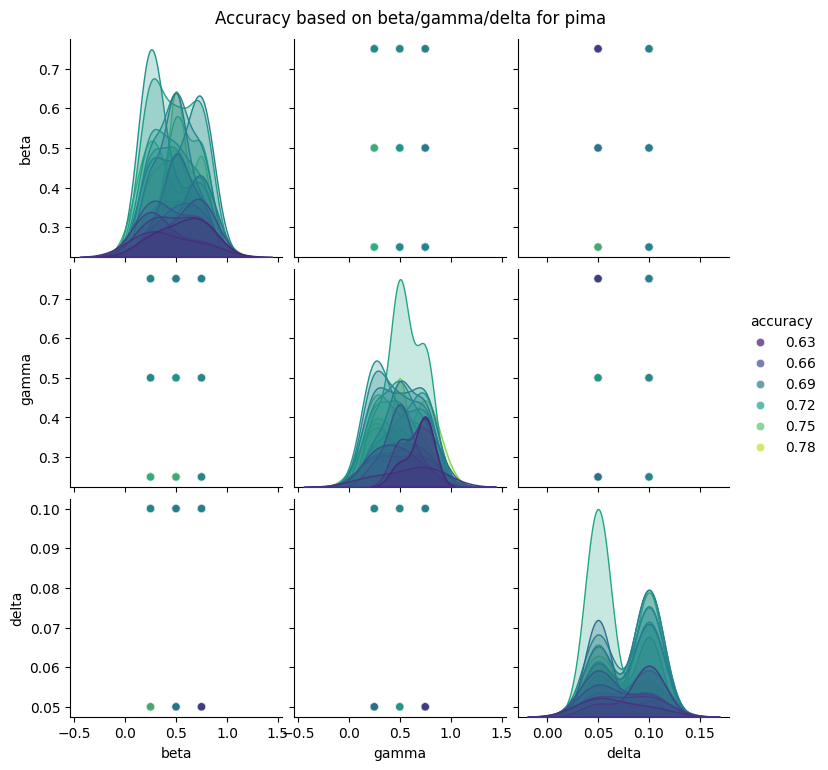

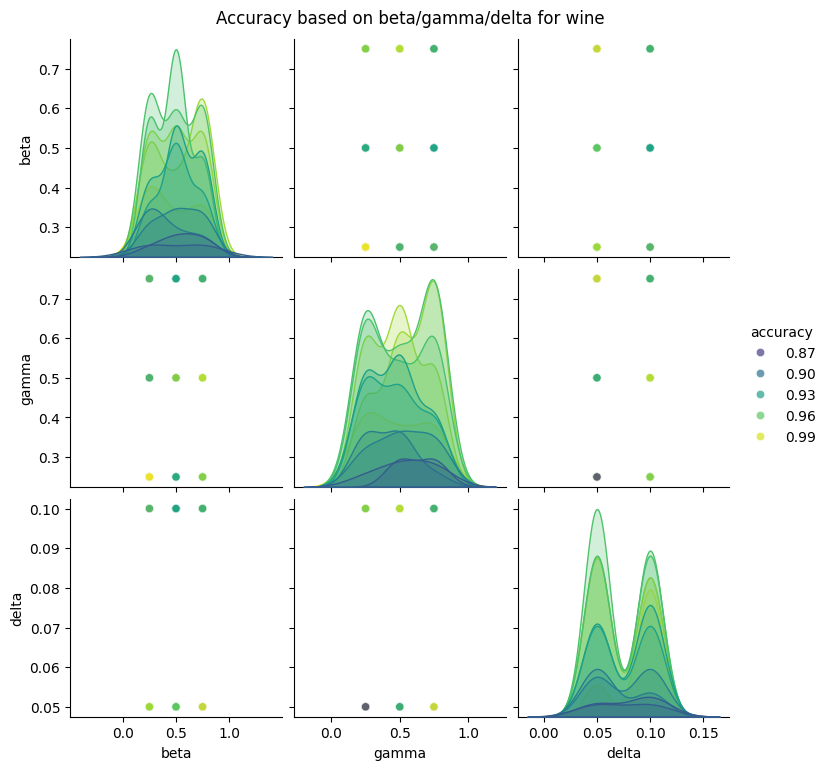

In [63]:
for dataset in datasets:
    sns.pairplot(df[df['dataset'] == dataset], vars=['beta', 'gamma', 'delta'], hue='accuracy',
             palette='viridis', plot_kws={'alpha': 0.7})
    plt.suptitle(f'Accuracy based on {greeks[0]}/{greeks[1]}/{greeks[2]} for {dataset}', y=1.02)
    plt.show()

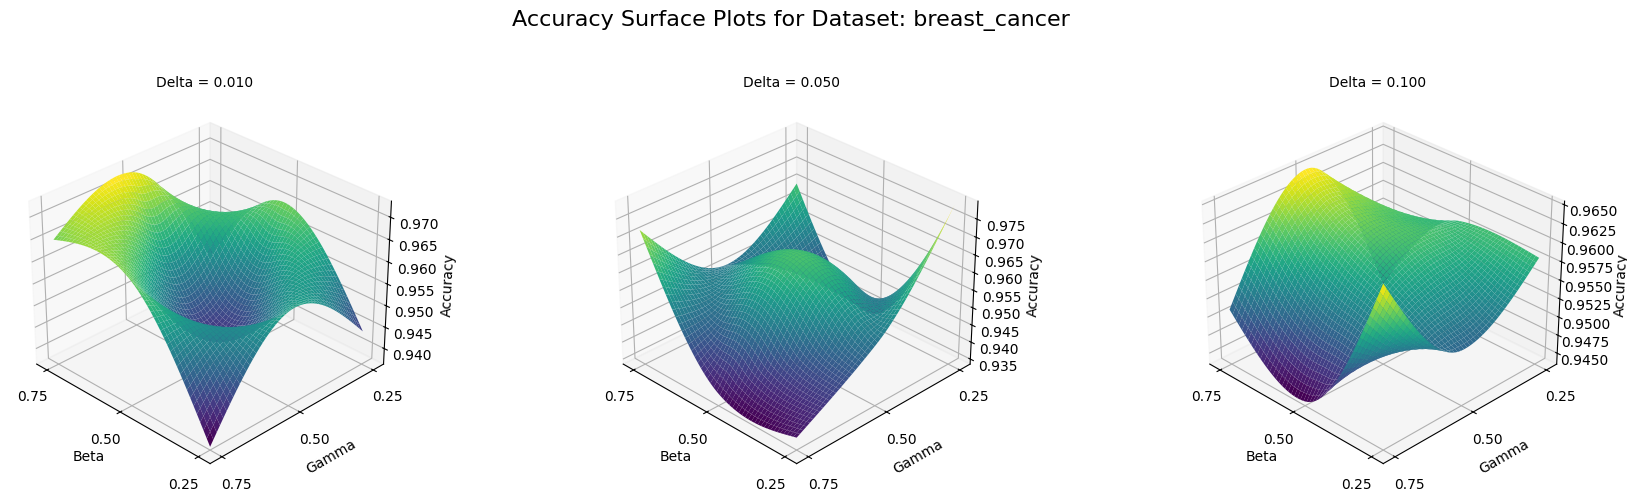

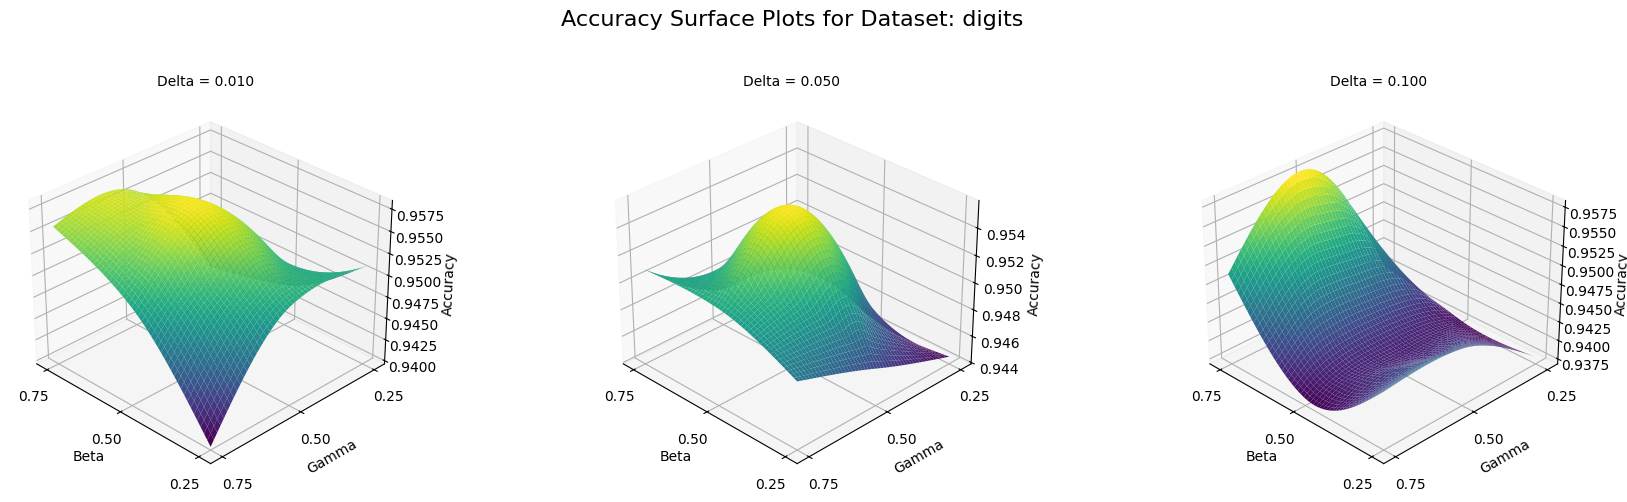

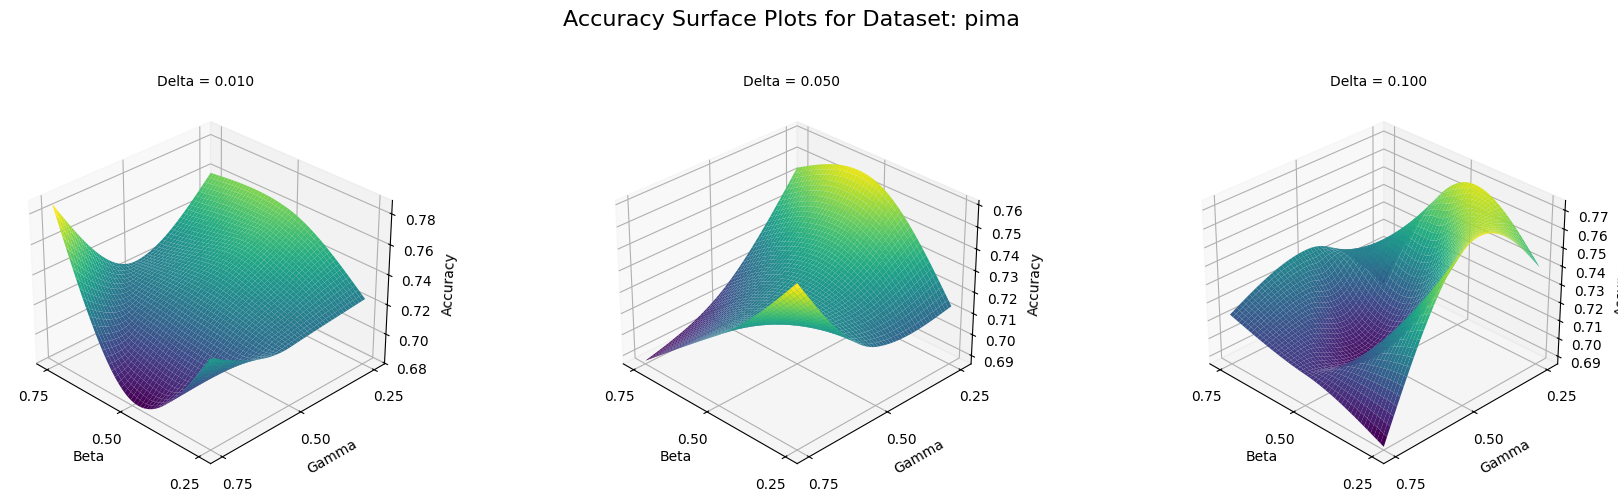

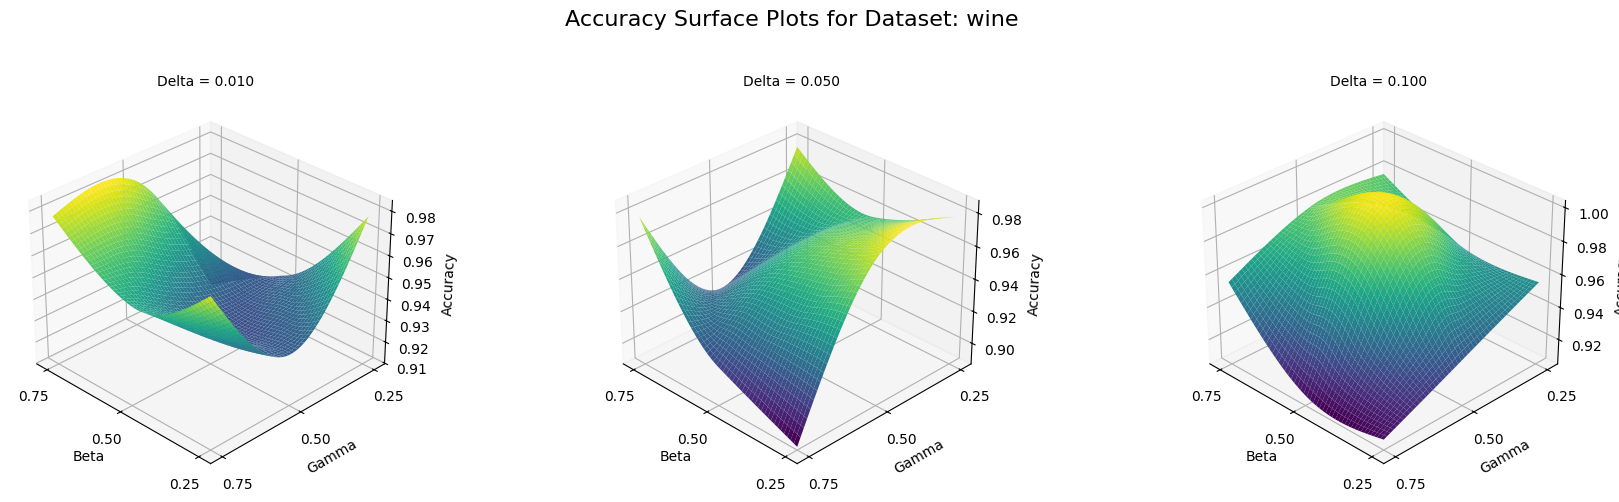

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import math

# Constants
greeks = ['beta', 'gamma', 'delta']

def plot_accuracy_surfaces_by_dataset(df):
    datasets = df['dataset'].unique()

    for dataset in datasets:
        df_dataset = df[df['dataset'] == dataset]
        delta_values = sorted(df_dataset['delta'].unique())
        n = len(delta_values)

        cols = min(n, 3)
        rows = math.ceil(n / cols)

        fig = plt.figure(figsize=(6 * cols, 5 * rows))
        fig.suptitle(f"Accuracy Surface Plots for Dataset: {dataset}", fontsize=16)

        for i, delta_val in enumerate(delta_values, start=1):
            df_slice = df_dataset[df_dataset['delta'] == delta_val]
            if df_slice.shape[0] < 4:
                continue

            x = df_slice['beta']
            y = df_slice['gamma']
            z = df_slice['accuracy']

            xi = np.linspace(x.min(), x.max(), 50)
            yi = np.linspace(y.min(), y.max(), 50)
            xi, yi = np.meshgrid(xi, yi)
            zi = griddata((x, y), z, (xi, yi), method='cubic')

            # Max accuracy point
            max_row = df_slice.loc[df_slice['accuracy'].idxmax()]
            max_acc = max_row['accuracy']
            beta_max = max_row['beta']
            gamma_max = max_row['gamma']

            ax = fig.add_subplot(rows, cols, i, projection='3d')
            surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')

            ax.set_title(f"Delta = {delta_val:.3f}", fontsize=10)
            ax.set_xlabel("Beta")
            ax.set_ylabel("Gamma")
            ax.set_zlabel("Accuracy")

            ax.set_xticks(sorted(df_slice['beta'].unique()))
            ax.set_yticks(sorted(df_slice['gamma'].unique()))
            ax.view_init(elev=30, azim=135)


        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Call the function
plot_accuracy_surfaces_by_dataset(df)


In [ ]:
# Define a function to plot 3D scatter
def plot_3d_metric(data, dataset, metric, title):
    data = data[data['dataset'] == dataset]
    fig = px.scatter_3d(
        data, x=greeks[0], y=greeks[1], z=greeks[2],
        color=metric, size_max=10,
        title=title,
        color_continuous_scale='Viridis',
        labels={greeks[0]: greeks[0], greeks[1]: greeks[1], greeks[2]: greeks[2]}
    )
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(
        scene=dict(
            xaxis=dict(tickvals=data[greeks[0]].unique(), title=greeks[0]),
            yaxis=dict(tickvals=data[greeks[1]].unique(), title=greeks[1]),
            zaxis=dict(tickvals=data[greeks[2]].unique(), title=greeks[2])
        )
    )
    fig.show()

# Create interactive 3D plots

for dataset in datasets:
    plot_3d_metric(grouped, dataset, 'accuracy', f'Accuracy vs {greeks[0]}/{greeks[1]}/{greeks[2]} ({dataset})')
    # plot_3d_metric(grouped, dataset, 'fitness_norm', f'Fitness vs {greeks[0]}/{greeks[1]}/{greeks[2]}')
    # plot_3d_metric(grouped_corr, dataset, 'spearman_corr', f'Spearman Correlation vs {greeks[0]}/{greeks[1]}/{greeks[2]}')


# RESULT COMPARISON PLOTS  

In [ ]:
def create_comparison_plot(df: pd.DataFrame) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        ("BaggingAccuracy", "Bagging"),
        ("SAAccuracy", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "_STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"Accuracy per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    plt.show()
    
    

In [ ]:
from tabulate import tabulate


files = glob.glob('./../res/metrics_*.csv')
dfs = [pd.read_csv(f) for f in files]

for df in dfs:
    df_aggregated = df.groupby(['nTrees']).agg(
        Dataset=('Dataset', 'first'),
        nTrees=('nTrees', 'first'),
        
        Bagging=('BaggingAccuracy', 'mean'),
        BaggingSA=('SAAccuracy', 'mean'),

        Bagging_STD=('BaggingAccuracy','std'),
        BaggingSA_STD=('SAAccuracy','std'),
    ).reset_index(drop=True).dropna()
    
    tmp = df_aggregated.copy().round(3)
    print(tabulate(tmp, headers='keys', tablefmt='pretty', showindex=False))
    create_comparison_plot(df_aggregated)
    print()
    
    

+---------+--------+---------+-----------+-------------+---------------+
| Dataset | nTrees | Bagging | BaggingSA | Bagging_STD | BaggingSA_STD |
+---------+--------+---------+-----------+-------------+---------------+
+---------+--------+---------+-----------+-------------+---------------+


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x400 with 0 Axes>